# Исследование объявлений о продаже квартир

В вашем распоряжении данные сервиса Яндекс.Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктов за несколько лет. Нужно научиться определять рыночную стоимость объектов недвижимости. Ваша задача — установить параметры. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность. 

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта, ближайшего парка и водоёма. 

### Откройте файл с данными и изучите общую информацию. 

Загружаю данные, и выгружаю первые 5 строк для начального ознакомления

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
data=pd.read_csv('/datasets/real_estate_data.csv', sep='\t')
print(data.head())

   total_images  last_price  total_area first_day_exposition  rooms  \
0            20  13000000.0       108.0  2019-03-07T00:00:00      3   
1             7   3350000.0        40.4  2018-12-04T00:00:00      1   
2            10   5196000.0        56.0  2015-08-20T00:00:00      2   
3             0  64900000.0       159.0  2015-07-24T00:00:00      3   
4             2  10000000.0       100.0  2018-06-19T00:00:00      2   

   ceiling_height  floors_total  living_area  floor is_apartment  ...  \
0            2.70          16.0         51.0      8          NaN  ...   
1             NaN          11.0         18.6      1          NaN  ...   
2             NaN           5.0         34.3      4          NaN  ...   
3             NaN          14.0          NaN      9          NaN  ...   
4            3.03          14.0         32.0     13          NaN  ...   

   kitchen_area  balcony    locality_name  airports_nearest  \
0          25.0      NaN  Санкт-Петербург           18863.0   
1       

Изучаю общую информацию и строю гистограмму для каждого столбца в таблице

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

array([[<AxesSubplot:title={'center':'total_images'}>,
        <AxesSubplot:title={'center':'last_price'}>,
        <AxesSubplot:title={'center':'total_area'}>,
        <AxesSubplot:title={'center':'rooms'}>],
       [<AxesSubplot:title={'center':'ceiling_height'}>,
        <AxesSubplot:title={'center':'floors_total'}>,
        <AxesSubplot:title={'center':'living_area'}>,
        <AxesSubplot:title={'center':'floor'}>],
       [<AxesSubplot:title={'center':'kitchen_area'}>,
        <AxesSubplot:title={'center':'balcony'}>,
        <AxesSubplot:title={'center':'airports_nearest'}>,
        <AxesSubplot:title={'center':'cityCenters_nearest'}>],
       [<AxesSubplot:title={'center':'parks_around3000'}>,
        <AxesSubplot:title={'center':'parks_nearest'}>,
        <AxesSubplot:title={'center':'ponds_around3000'}>,
        <AxesSubplot:title={'center':'ponds_nearest'}>],
       [<AxesSubplot:title={'center':'days_exposition'}>, <AxesSubplot:>,
        <AxesSubplot:>, <AxesSubplot:>]], d

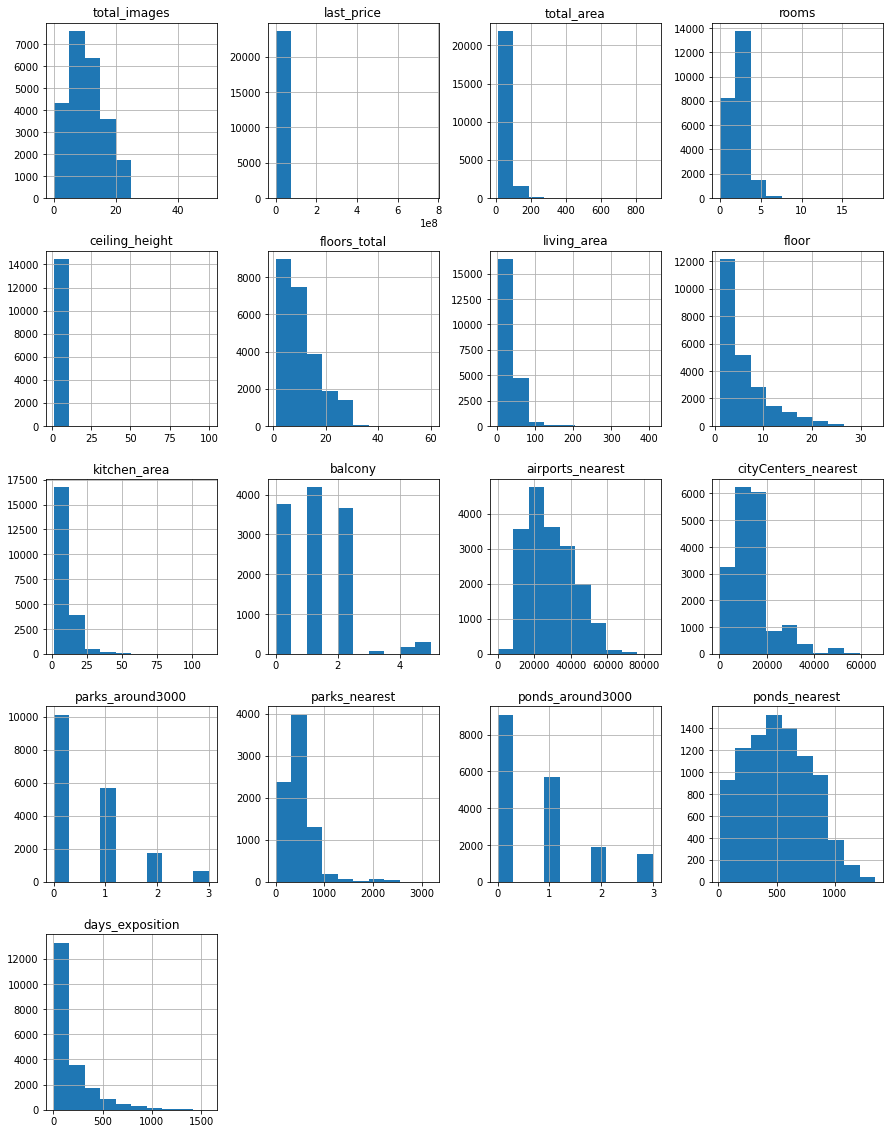

In [2]:
data.info()
data.hist(figsize=(15,20))

### Предобработка данных

In [3]:
data.isna().sum()

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height           9195
floors_total               86
living_area              1903
floor                       0
is_apartment            20924
studio                      0
open_plan                   0
kitchen_area             2278
balcony                 11519
locality_name              49
airports_nearest         5542
cityCenters_nearest      5519
parks_around3000         5518
parks_nearest           15620
ponds_around3000         5518
ponds_nearest           14589
days_exposition          3181
dtype: int64

##### Обрабатываем данные, добавленные пользователем

1. Если пользователь не добавил, балкон скорее всего его нет в квартире, заменяю пропуск на 0
2. Высоту потолков заменила на медианное значение, как правило это значение от 2х до 3х метров
3. Площадь кухни и площадь жилой площаде также заменила на медианное значение
4. Апартаменты заменилв  на значение и пропуски заменила на False, скорей всего ежилая недвижимостьсли пользователь не указал что это аппартаменты, значит это 

In [4]:
data['balcony']=data['balcony'].fillna(0) 
data['ceiling_height']=data['ceiling_height'].fillna(data['ceiling_height'].median())
data['living_area']=data['living_area'].fillna(data['living_area'].median())
data['kitchen_area']=data['kitchen_area'].fillna(data['kitchen_area'].median())
data['is_apartment']=data['is_apartment'].fillna(False)
data['locality_name']=data['locality_name'].fillna('unknown')
data['cityCenters_nearest']=data['cityCenters_nearest'].fillna(0)

##### Обрабатываем картографические данные

1. Для столбца с пропущенными данными до аэропорта сгруппирую по названию населённого пункта и составлю функцию где в пропущенные значения буду добавлять медианные данные. Осталось 5394 пропуска, оставлю остальные не заполненные, так как, по другим параметрам нельзя определить расстояние
2. Расстояние до центра города не заполняла поскольку по имеющимся данным мы это оценить не можем
3. Число парков и водоёмов в радиусе 3 км заполнила 0, поскольку если эти данные пропущены скорей всего их просто нет
4. Пропуски в parks_nearest ponds_nearest оставила, хотя их много, но оценить расстояние до водоёмов и парков по имеющимся данным нельзя
5. Пропуски в days_exposition также оставила, так как скорей всего, если объявление не снято значит квартира еще не продана


In [5]:
airport_median=data.groupby('locality_name')['airports_nearest'].median()
for name in data['locality_name'].unique():
    data.loc[(data['airports_nearest'].isna())&(data['locality_name']==name), 'airports_nearest']=airport_median[name]
print(data['airports_nearest'].isna().sum())

5386


In [6]:
data['parks_around3000']=data['parks_around3000'].fillna(0)
data['ponds_around3000']=data['ponds_around3000'].fillna(0)


<AxesSubplot:>

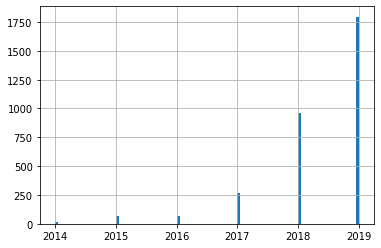

In [7]:
data['first_day_exposition']=pd.to_datetime(data['first_day_exposition'], format='%Y-%m-%dT%H:%M:%S')
data['year_exposition']=data['first_day_exposition'].dt.year#добавляем год
data.query('days_exposition.isna()')['year_exposition'].hist(bins=100)

##### Меняем тип данных где это возможно

Поменяла тип данных в столбцах balcony и last_price на вещественный, столбец с датой в дату и время. В остальных столбцах есть пропуски поменять тип не получится. Тип данных поменяли, чтобы потом легче было с ними работать

In [8]:
data['balcony']=data['balcony'].astype('int')
data['last_price']=data['last_price'].astype('int')
data['first_day_exposition']=pd.to_datetime(data['first_day_exposition'], format='%Y-%m-%dT%H:%M:%S')

##### Изучаем уникальные значения в названиях городов и приводим всё к одному виду

In [9]:
data['locality_name'].duplicated().sum()
data['locality_name'].unique()
data['locality_name']=data['locality_name'].str.replace('посёлок', 'поселок')
data['locality_name']=data['locality_name'].str.replace('городской поселок', 'поселок городского типа')

##### Аномалии в столбцах

In [43]:
data.loc[data['ceiling_height']>=20, 'ceiling_height']=data['ceiling_height']/10
data.loc[(data['ceiling_height']>=1)&(data['ceiling_height']<2), 'ceiling_height']=2
data.loc[data['last_price']==763000000, 'last_price']=data['last_price']/10
data.query('last_price<500000')
data.loc[data['last_price']==12190, 'last_price']=data['last_price']*1000

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,year_exposition,square_meter_price,day_of_the_week,month_exposition,type_floor,city_center,month,day,week_day,year
5698,7,450000.0,42.0,2017-07-31,2,2.65,1.0,23.0,1,False,...,2017,10714.285714,0,7,первый,0,7,31,0,2017
6859,6,490000.0,40.0,2017-12-11,1,2.65,5.0,30.0,3,False,...,2017,12250.000000,0,12,другой,0,12,11,0,2017
9581,7,450000.0,43.4,2018-08-31,2,2.65,5.0,30.3,3,False,...,2018,10368.663594,4,8,другой,0,8,31,4,2018
10782,3,490000.0,29.1,2016-05-05,1,2.50,5.0,17.0,5,False,...,2016,16838.487973,3,5,последний,0,5,5,3,2016
14911,5,430000.0,54.0,2018-06-26,2,2.65,3.0,30.0,3,False,...,2018,7962.962963,1,6,последний,0,6,26,1,2018
16032,8,480000.0,32.0,2019-01-06,1,2.65,2.0,16.0,1,False,...,2019,15000.000000,6,1,первый,0,1,6,6,2019
16219,14,450000.0,38.5,2018-07-11,2,2.65,2.0,30.0,1,False,...,2018,11688.311688,2,7,первый,0,7,11,2,2018
16274,18,440000.0,40.0,2018-07-10,1,2.65,5.0,30.0,1,False,...,2018,11000.000000,1,7,первый,0,7,10,1,2018
17456,7,430000.0,30.4,2019-04-22,1,2.65,2.0,16.0,1,False,...,2019,14144.736842,0,4,первый,0,4,22,0,2019
17676,0,450000.0,36.5,2018-02-01,1,2.65,5.0,17.3,4,False,...,2018,12328.767123,3,2,другой,0,2,1,3,2018


Видимые аномалии обработала в столбцах высота потолка и число комнат. Аномальную высоту потолков (больше 20 метров) разделила на 10, так как скорее всего ошиблись при введении данных. Также высота потолка не может быть 1 метр, все эти значения заменила на 2м. Стоимость квартиры 760 000 000 рублей маловероятна(учитывая что квартира с максимальной площадью в 900 кв м стоит практически в два раза дешевле), скорей всего добавили лишний ноль к цене.

ВЫВОД: Всего у нас 23699 записи. В ходе предобработки данных были выявлены пропущенные значения, часть данных есть возможность заполнить логическими данными(например, число балконов, высоту потолков, жилая площадь, площадь кухни и т.д.). Там где данные нельзя оценить, оставила пропуски, либо заменила на 0(как правило, это картографические данные. Проверила уникальные значения в названиях городов, привела данные к общему виду. Также заменила аномальные значения, где они действительно явные и невозможны в практике. Поменяла тип данных в некоторых столбцах, чтобы привести данные к более корректному виду, и чтобы в дальнейшем было легче их анализировать.

### Посчитайте и добавьте в таблицу новые столбцы

In [11]:
data['square_meter_price']=data['last_price']/data['total_area']
data['day_of_the_week']=data['first_day_exposition'].dt.weekday
data['month_exposition']=data['first_day_exposition'].dt.month
data['year_exposition']=data['first_day_exposition'].dt.year

In [12]:
def type_floors(row): 
    floor=row['floor']
    floors_total=row['floors_total']
    if floor==1:
        return 'первый'
    if floor==floors_total:
        return 'последний'
    return 'другой'
data['type_floor']=data.apply(type_floors, axis=1)

In [13]:
data['city_center']=data['cityCenters_nearest']/1000 
data['city_center']=data['city_center'].astype('int')

### Проведите исследовательский анализ данных

#### Изучаем данные и строим гистограммы

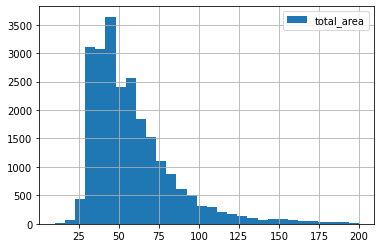

In [14]:
data['total_area'].hist(bins=30, legend=True, range=(10, 200))

Судя по гистограмме, наибольшее число квартир с полощадью от 30 до 50 метром

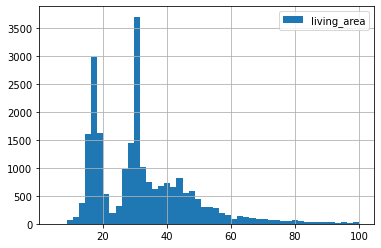

In [15]:
data['living_area'].hist(bins=50,legend=True, range=(5, 100))
plt.show()

Наибольшее значение жилой площади около 30 кв м

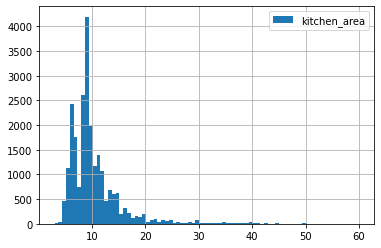

In [16]:
data['kitchen_area'].hist(bins=80,legend=True, range=(3, 60))
plt.show()

Большинство квартир с площадью кухни около 9 метров

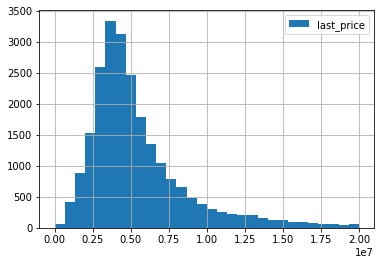

In [17]:
data['last_price'].hist(bins=30,legend=True, range=(0, 20000000))
plt.show()

Большинство квартир стоят до 10 млн

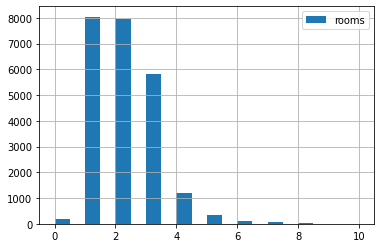

In [18]:
data['rooms'].hist(bins=20,legend=True, range=(0,10))
plt.show()

Большинство однокомнатных квартир, на втором месте двухкомнатные

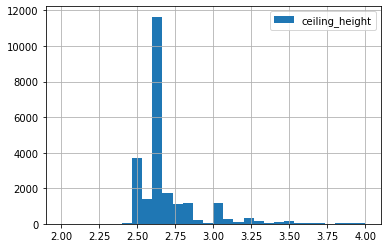

In [19]:
data['ceiling_height'].hist(bins=30, range=(2,4) ,legend=True)
plt.show()

Большинство квартир с ввысотой потолков 2.6 м

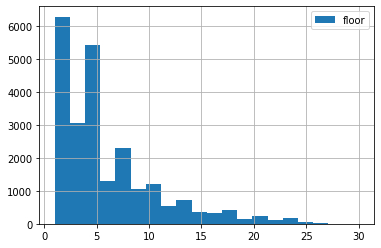

In [20]:
data['floor'].hist(bins=20, legend=True, range=(1,30))
plt.show()

Большинство квартир расположены с первого по пятый этаж

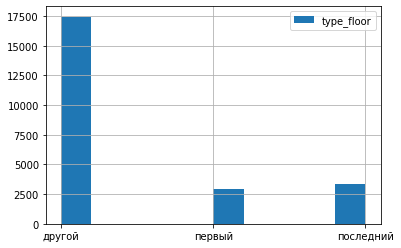

In [21]:
data['type_floor'].hist(legend=True)
plt.show()

Большинство квартир входят в категорию "другой", то есть находятся ни на первом ни на последнем этаже

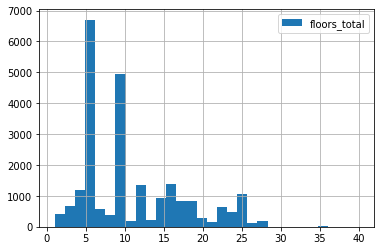

In [22]:
data['floors_total'].hist(legend=True, range=(1,40), bins=30)
plt.show()

Большинство квартир продаются в пятиэтажках

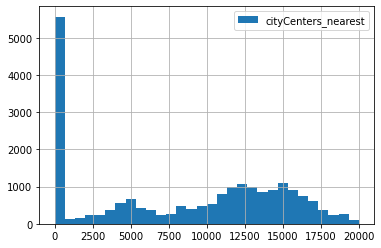

In [23]:
data['cityCenters_nearest'].hist(legend=True, bins=30, range=(0, 20000))
plt.show()

Большинство квартир находятся недалеко от центра города

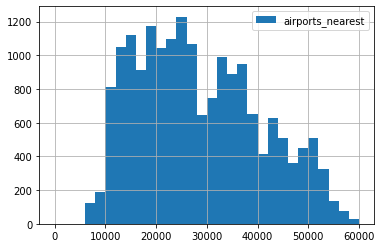

In [24]:
data['airports_nearest'].hist(legend=True, bins=30, range=(0,60000))
plt.show()

Большинство квартир находятся на расстоянии 25 км от аэропорта

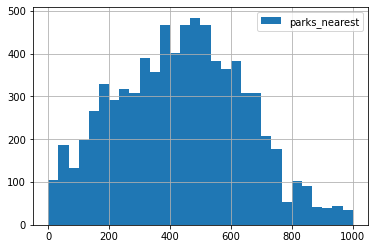

In [25]:
data['parks_nearest'].hist(legend=True, bins=30, range=(0, 1000))
plt.show()

У большинства квартир парк находится в радиусе 500 метров

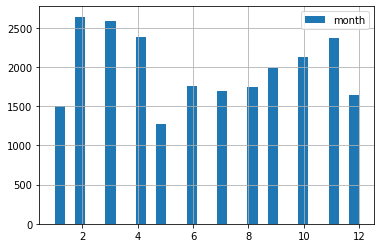

In [26]:
data['month'] = data['first_day_exposition'].dt.month
data['month'].hist(legend=True, bins=30, range=(1,12))
plt.show()

Большинство публикаций о продаже в февралеб марте и ноябреб в летние месяце количество публикаций снижается

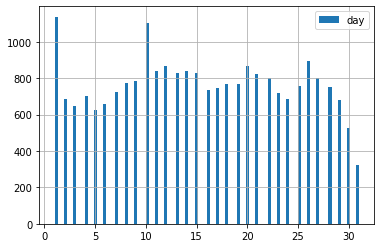

In [27]:
data['day']=data['first_day_exposition'].dt.day
data['day'].hist(legend=True, range=(1,31), bins=100)
plt.show()

Большинство публикаций 1го и 10 числа месяца, в остальные дни распределяется в целом равномерно

#### Изучаем как быстро продавались квартиры

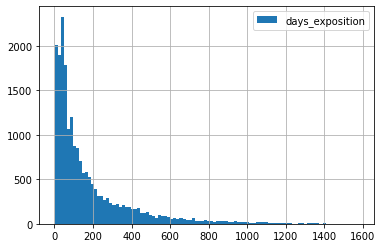

Среднее по количеству дней продажи: 180.88863436982163
Медиана по количеству дней продажи: 95.0


In [28]:
data['days_exposition'].hist(bins=100, legend=True)
plt.show()
print('Среднее по количеству дней продажи:' ,data['days_exposition'].mean())
print('Медиана по количеству дней продажи:',data['days_exposition'].median())

Среднее значение достаточно сильно отличается от медианы, это говорит о том что есть выбросы. Судя по гистограмме, достаточно быстро продаются квартиры в первые 30 дней, а необычно долго квартиры продаются более 1000 дней.

#### Изучим от чего зависит цена

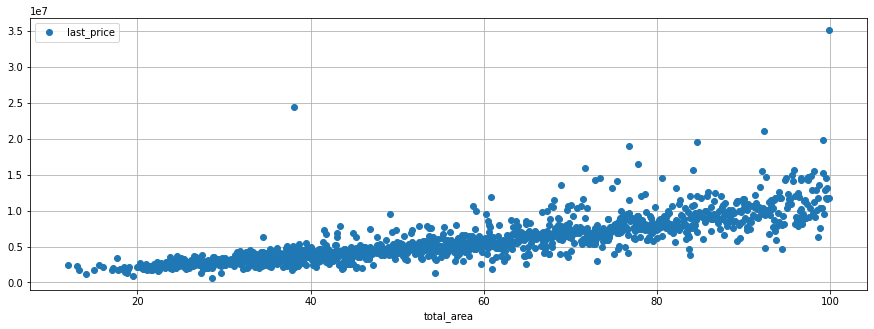

Корреляция цены от площади: 0.7033616090441033


In [29]:
(
    data.query('total_area<100').
    pivot_table(index='total_area', values='last_price').
    plot(grid=True, figsize=(15,5), style='o')#зависимость ценыот общей площади
)
plt.show()
print('Корреляция цены от площади:', data['last_price'].corr(data['total_area']))

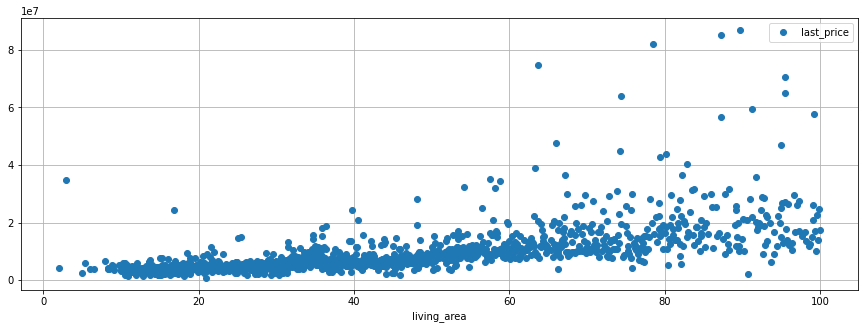

Корреляция цены от площади: 0.5748336653570923


In [30]:
(
    data.query('living_area<100').
    pivot_table(index='living_area', values='last_price').
    plot(grid=True, figsize=(15,5), style='o')
)
plt.show()
print('Корреляция цены от площади:', data['last_price'].corr(data['living_area']))

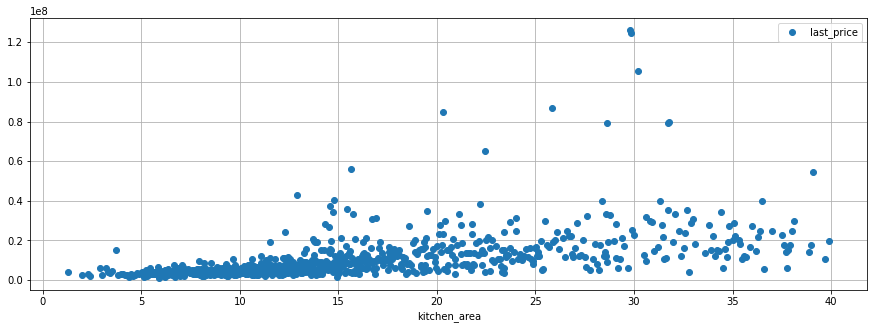

Корреляция цены от площади кухни: 0.49360667294147453


In [31]:
(
    data.query('kitchen_area<40').
    pivot_table(index='kitchen_area', values='last_price').
    plot(grid=True, figsize=(15,5), style='o')
)
plt.show()
print('Корреляция цены от площади кухни:', data['last_price'].corr(data['kitchen_area']))

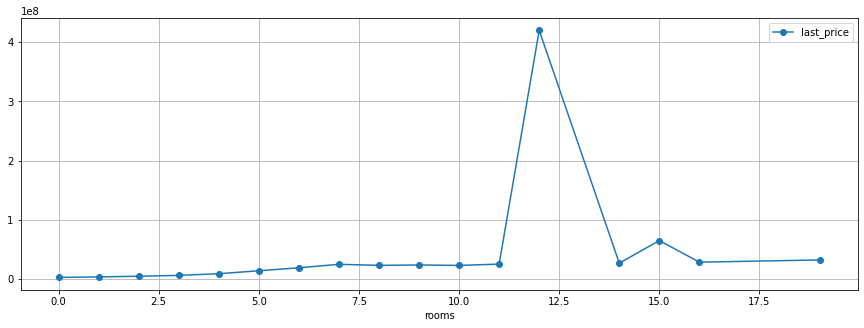

Корреляция цены от количества комнат: 0.3931186317944764


In [32]:
(
    data.pivot_table(index='rooms', values='last_price', aggfunc='median').
    plot(grid=True, figsize=(15,5), style='o-')
)
plt.show()
print('Корреляция цены от количества комнат:', data['last_price'].corr(data['rooms']))

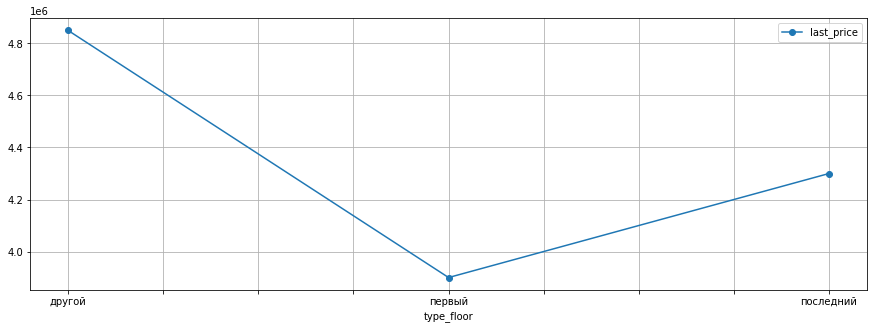

In [33]:
(
    data.pivot_table(index='type_floor', values='last_price', aggfunc='median').
    plot(grid=True, figsize=(15,5), style='o-')
)
plt.show()

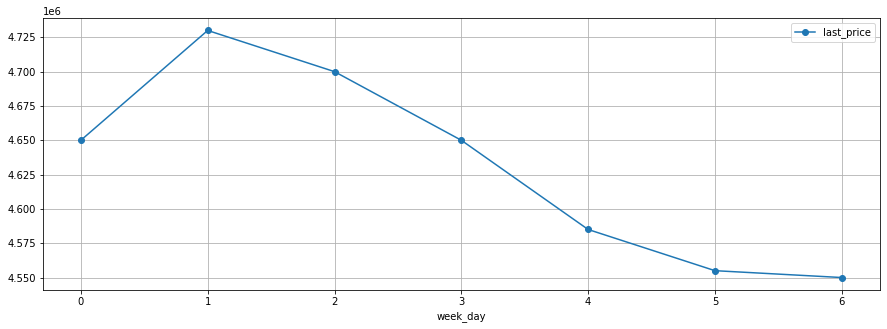

Корреляция цены от дня недели размещения объявления: 0.005261583666448787


In [34]:
data['week_day']=data['first_day_exposition'].dt.weekday
(
    data.pivot_table(index='week_day', values='last_price', aggfunc='median').
    plot(grid=True, figsize=(15,5), style='o-')
)
plt.show()
print('Корреляция цены от дня недели размещения объявления:', data['last_price'].corr(data['day']))

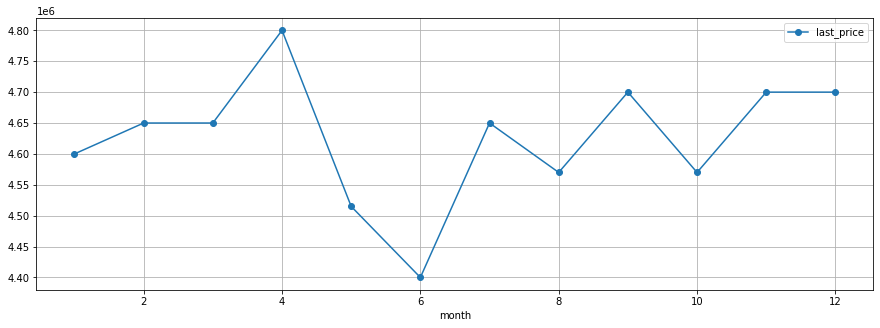

Корреляция цены от месяца публикации: 0.0008924353778632499


In [35]:

(
    data.pivot_table(index='month', values='last_price', aggfunc='median').
    plot(grid=True, figsize=(15,5), style='o-')
)
plt.show()
print('Корреляция цены от месяца публикации:', data['last_price'].corr(data['month']))

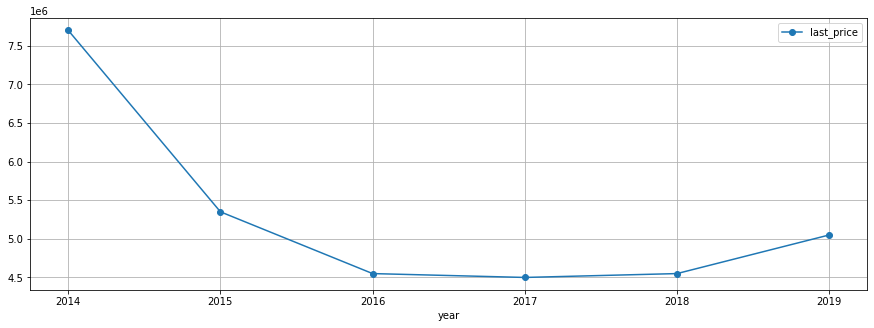

Корреляция цены от года публикации: -0.047183205985824296


In [36]:
data['year']=data['first_day_exposition'].dt.year
(
    data.pivot_table(index='year', values='last_price', aggfunc='median').
    plot(grid=True, figsize=(15,5), style='o-')
)
plt.show()
print('Корреляция цены от года публикации:', data['last_price'].corr(data['year']))

ВЫВОД: Больше всего на цену влияет общая площадб квартиры(тем больше площадь-выше цена), влияют на цену также площадь кухни и жилая площадь, но меньше чем общая. Количество комнат также влияют на цену квартиры. В мае и июне цена снижается,в июне самые низкие цены в разресе всего года. Также с середины недели цена начинает падать к выходным.Интересная зависимость от года- с 2014 года цена стала падать влоть до 2018 года

#### Среднее стоимость квадратного метра в 10 населённых пунктах с наибольшим количеством объявлений

In [37]:
locality_name_pivot=data.pivot_table(index='locality_name', values='square_meter_price', aggfunc=['count', 'mean'])
locality_name_pivot.columns=['Количество', 'Стоимость одного квадратного метра']
locality_name_pivot.query('Количество>201')

,Количество,Стоимость одного квадратного метра
locality_name,,
Всеволожск,398,68654.473986
Выборг,237,58141.909153
Гатчина,307,68746.146763
Колпино,338,75424.579098
Пушкин,369,103125.819291
Санкт-Петербург,15721,114739.807725
деревня Кудрово,299,92473.547576
поселок Мурино,556,85681.762601
поселок Парголово,327,90175.913458


Самая высокая стоимость квадратного метра в Санкт-Петербурге, самая низкая в Выборге

#### Вычисляем среднюю цену каждого километра

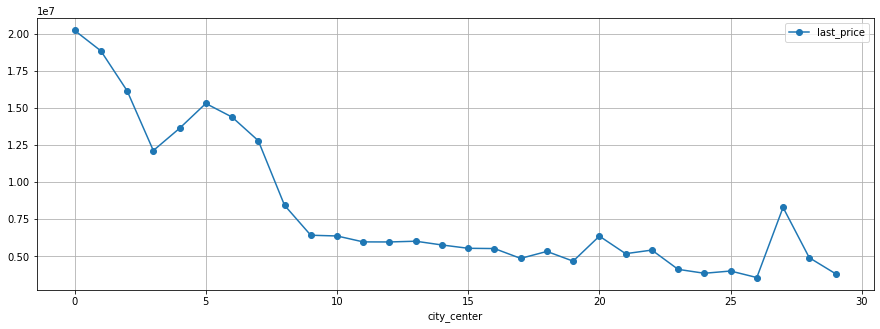

In [38]:
(
    data.query('locality_name=="Санкт-Петербург"').
    pivot_table(index='city_center', values='last_price').
    plot(grid=True,style='o-', figsize=(15,5))
)
plt.show()

В центре города самые дорогие квартиры, на расстоянии 5 км от центра, цены резко начинают падать

Чем дальше от центра, тем ниже стоимость квартиры

### Общий вывод

1. В среднем квартира продаётся за 95 дней, самые дорогие квартиры в Санкт-Петербурге(причем цена зависит от удаленности от центра, чем дальше-дешевле), самые дешевые квартиры в Выборге.
2. На цену квартиры в первую очередь влияет площадь квартиры, чуть меньше на цену влияет площадь кухни и жилая площадь. Квартиры на первом и последнем этажах гораздо дешевле, чем на остальных этажах. Дороже выкладываются объявления в зимние месяцы(исключение-январь), в летние месяцы цены падают. 
3. С 2014 года цены стали резко падать до 2017 года, затем цены стали опять расти
4. Что касаетсяСанкт-Петербурга, то ожидаемо, что самые дорогие квартиры в центре города, за 5 км от центра цены стали резко падать